In [1]:
import numpy as np 
import pandas as pd
from scipy.io import loadmat
import matplotlib.pyplot as plt
import math

import torch
import torch.nn as nn
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Load an individual data file

Shape is (N x 78) - where 78 is a fixed value, N is the number of frames

In [2]:
matFile = loadmat('./emo_data/train/P336D.mat')
matFile.keys()
data = matFile['data']

print(data.shape)

(13376, 78)


In [3]:
# X coordinates of 22 body joints
X_coords = data[:, 0:22]
# Y coordinates of 22 body joints
Y_coords = data[:, 22:44]
# Z coordinates of 22 body joints
Z_coords = data[:, 44:66]

## Some common graph functions

In [4]:
# Plot a single block of coordinate data
# Input: data (NxM)
def plot_single_line_coord_block(data):
    dims = data.shape[1]
    for i in range(dims):
        plt.plot(data[:, i])
        
    return plt.show()

# Plot all three coordinate blocks together
def plot_all_coords(X, Y, Z):
    dims = X.shape[1]
    for i in range(dims):
        plt.plot(X[:, i], color='blue')
        plt.plot(Y[:, i], color='green')
        plt.plot(Z[:, i], color='red')
        
    plt.xlabel('Frames')
    plt.ylabel('Coordindate Position')
    plt.title('Coordinate data (Blue - X, Green - Y, Red - Z)')
    return plt.show()

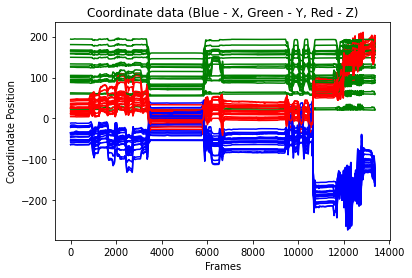

In [5]:
plot_all_coords(X_coords, Y_coords, Z_coords)

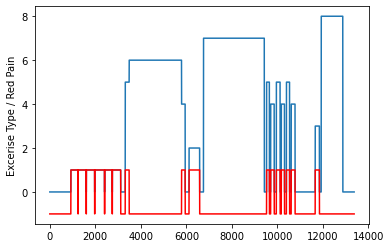

In [6]:
plt.plot(data[:, 70])
plt.plot(data[:, 71], color = 'red')
plt.ylabel('Excerise Type / Red Pain')
plt.show()

In [37]:
SW_LENGTH = 180 # 3 seconds
new_data = []
new_data_labels = []

count = 0
start = 0
end = start + SW_LENGTH
T = data.shape[0]

while start < T:
    currentCoords = data[start:end, 0:66]
    behaviours = np.array(data[start:end, 72]).astype('int64')
    majority_protective_behaviour = np.argmax(np.bincount(behaviours))
    A, B = currentCoords.shape
    if A < 180:
        # We need to pad
        currentCoords = np.pad(currentCoords, ((0, 180 - A), (0, 0)))
        
    new_data.append(currentCoords)
    new_data_labels.append(majority_protective_behaviour)
    
    # Update pointers
    count += 1
    start += SW_LENGTH
    end = start + SW_LENGTH

new_data = np.array(new_data)
new_data_labels = np.array(new_data_labels)
print(new_data.shape)
print(new_data_labels.shape)

(75, 180, 66)
(75,)


In [38]:
class LSTM(nn.Module):
    def __init__(self, input_size=66, hidden_layer_size=1024, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        # LSTM hidden cell
        self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size),
                            torch.zeros(1, 1, self.hidden_layer_size))

        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [39]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for i in range(new_data.shape[0]):
    optimizer.zero_grad()
    model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size), torch.zeros(1, 1, model.hidden_layer_size))

    _data = torch.Tensor(new_data[i])
    _label = torch.Tensor([new_data_labels[i]])

    pred = model(_data)
    loss = loss_function(pred, _label)
    loss.backward()
    optimizer.step()
    
    print('Loss, ', loss.item())

Loss,  0.02242157980799675
Loss,  7.9523820877075195
Loss,  1.4123666286468506
Loss,  0.06543511152267456
Loss,  0.05094955489039421
Loss,  0.5975462198257446
Loss,  0.3004366159439087
Loss,  0.0973721444606781
Loss,  0.01955597847700119
Loss,  0.0010131383314728737
Loss,  0.018086954951286316
Loss,  0.04189139977097511
Loss,  0.06532080471515656
Loss,  0.10734472423791885
Loss,  0.10896164178848267
Loss,  0.10806089639663696
Loss,  0.10277093201875687
Loss,  0.09021582454442978
Loss,  1.4548580646514893
Loss,  1.5993754863739014
Loss,  1.1245510578155518
Loss,  0.722774863243103
Loss,  0.41822633147239685
Loss,  0.11018352955579758
Loss,  0.011118955910205841
Loss,  0.012027649208903313
Loss,  0.040329091250896454
Loss,  0.07686697691679001
Loss,  0.11348208785057068
Loss,  0.1417972594499588
Loss,  0.16152192652225494
Loss,  0.17010776698589325
Loss,  0.1849122792482376
Loss,  0.1396452933549881
Loss,  0.09962639212608337
Loss,  0.06740204244852066
Loss,  0.04011228680610657
Loss,  0

### 